In [8]:
import pandas as pd
import numpy as np
import requests
import os
import sys
from sklearn.metrics import classification_report

def get_gold_file(args):
    headers = {'Accept': 'application/json'}
    lines = requests.get(args.meta_data, headers=headers).json()
    df = pd.DataFrame(lines)
    return df

def get_prediction_file(args):
    if not os.path.exists(args.file_path):
        print(f"{args.file_path} not exist!")
        sys.exit()

    df = pd.read_csv(args.file_path)
    return df

# Set the arguments directly
class Args:
    file_path = "team.bertmodel.TaskA.1.csv" #Cleaned, separate
    #file_path = "team.bertmodel.TaskA.2.csv" #Uncleaned, separate 
    #file_path = "team.bertmodel.TaskA.2.csv" #Cleaned, combined
    meta_data = 'https://people.cs.pitt.edu/~zhexiong/data/meta_data_test.json'

args = Args()

def get_task_predictions(args):
    df_gold = get_gold_file(args)
    df_pred = get_prediction_file(args)
    df = pd.merge(df_pred, df_gold, on="tweet_id")
    df = df[df["tweet_id"] != 1321141824300306433]  # remove this tweet as it is not available online
    if len(df) != 299:
        print(f"Error! You only have {len(df)} predictions!")
        sys.exit()

    # stance prediction
    if "stance_x" in df.columns:
        print(f"you are evaluating stance predictions:\n{args.file_path}.")
        pred_list = df["stance_x"].tolist()
        gold_list = df["stance_y"].tolist()
    elif "persuasiveness_x" in df.columns:
        print(f"you are evaluating persuasiveness predictions:\n{args.file_path}.\n")
        pred_list = df["persuasiveness_x"].tolist()
        gold_list = df["persuasiveness_y"].tolist()
    else:
        print("please run 'check_submission_format.py' to check your submission format!")
        sys.exit()

    label_dict = {'support': 1, 'oppose': 0, 'yes': 1, 'no': 0}
    pred_list = [label_dict[x] for x in pred_list]
    gold_list = [label_dict[x] for x in gold_list]

    return pred_list, gold_list

def get_evaluation_report(pred, gold):
    rp = classification_report(pred, gold, output_dict=False, digits=4)
    print(rp)

# Run the evaluation
pred_list, gold_list = get_task_predictions(args)
get_evaluation_report(pred_list, gold_list)

you are evaluating stance predictions:
team.bertmodel.TaskA.2.csv.
              precision    recall  f1-score   support

           0     0.8177    0.9136    0.8630       162
           1     0.8814    0.7591    0.8157       137

    accuracy                         0.8428       299
   macro avg     0.8495    0.8364    0.8393       299
weighted avg     0.8469    0.8428    0.8413       299



In [16]:
# The labelled dataset was provided by the organisers after the declaration of results
import seaborn as sns
import matplotlib.pyplot as plt
labelled_test = pd.read_csv("labelled_testdata.csv")
labelled_test.head()

,tweet_id,tweet_url,topic,stance,persuasiveness,split,tweet_text
0,1204712613394944000,https://t.co/qKG8HMQQPp,abortion,oppose,yes,test,LAUNCH of our mobile billboards as part of our...
1,1314687877482242054,https://t.co/hTNb7Vajeq,abortion,oppose,no,test,"Yesterday, the Supreme Court of the United Sta..."
2,1323088699123552257,https://t.co/zjGHXEmkUF,abortion,support,no,test,Abortion at home is safe and effective. \n\nWe...
3,1343172775696084992,https://t.co/8N93Yz08mC,abortion,oppose,yes,test,Is Abortion in Israel Holding Back Moshiach? T...
4,1349536776407416833,https://t.co/JEJfDUal2L,abortion,oppose,yes,test,"“KS want limits on the abortion industry, Valu..."


In [26]:
TaskA_result = pd.read_csv("team.bertmodel.TaskA.1.csv") #Cleaned, separate
#TaskA_result = pd.read_csv("team.bertmodel.TaskA.2.csv") #Uncleaned, separate
#TaskA_result = pd.read_csv("team.bertmodel.TaskA.3.csv") #Cleaned, combined

TaskA_result.rename(columns={TaskA_result.columns[1]: "stance"}, inplace=True)
TaskA_result["stance"] = TaskA_result["stance"].replace({0: "oppose", 1: "support"})
TaskA_result.rename(columns={'stance': 'predicted_stance'}, inplace=True)
TaskA_result.head()

,tweet_id,predicted_stance
0,1246096866942607362,support
1,1321259279500906496,oppose
2,1239679202531532802,support
3,1242599596838146048,oppose
4,1237439219544371200,oppose


In [27]:
labelled_results = TaskA_result.merge(labelled_test[['tweet_id', 'stance','topic']], on='tweet_id', how='left')
labelled_results = labelled_results.loc[labelled_results['tweet_id'] != 1321141824300306433]
labelled_results.head()

,tweet_id,predicted_stance,stance,topic
0,1246096866942607362,support,support,gun_control
1,1321259279500906496,oppose,oppose,gun_control
2,1239679202531532802,support,support,gun_control
3,1242599596838146048,oppose,oppose,gun_control
4,1237439219544371200,oppose,oppose,gun_control


F1 Score of the Result: 0.8393
Accuracy: 0.8428


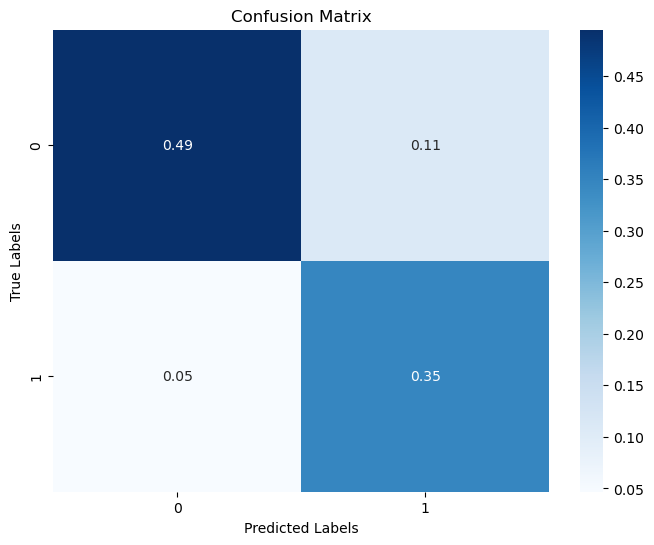

Topic: gun_control, F1 Score: 0.7652
Topic: abortion, F1 Score: 0.9123


In [28]:
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'true_labels' and 'predicted_labels' are columns in the DataFrame
true_labels = labelled_results['stance']
predicted_labels = labelled_results['predicted_stance']

# Calculate the F1 score on validation_data using the best model
f1_score_best_model = f1_score(true_labels, predicted_labels, average='macro')
print("F1 Score of the Result: {:.4f}".format(f1_score_best_model))

# Calculate accuracy
v_accuracy = accuracy_score(true_labels, predicted_labels)
print("Accuracy: {:.4f}".format(v_accuracy))

# Compute the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Normalize the confusion matrix and convert to percentages
total_samples = np.sum(cm)
cm_percent = cm / total_samples

# Plot the confusion matrix heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm_percent, annot=True, cmap="Blues", fmt=".2f", xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.savefig('confusion_matrix.png')

# Display the plot
plt.show()

# Calculate topic-specific F1 scores
unique_topics = labelled_results['topic'].unique()
f1_scores_by_topic = {}

for topic in unique_topics:
    topic_data = labelled_results[labelled_results['topic'] == topic]
    true_labels_topic = topic_data['stance']=='oppose'
    predicted_labels_topic = topic_data['predicted_stance']=='oppose'
    
    f1_topic = f1_score(true_labels_topic, predicted_labels_topic)
    f1_scores_by_topic[topic] = f1_topic

# Print topic-specific F1 scores
for topic, f1_topic in f1_scores_by_topic.items():
    print(f"Topic: {topic}, F1 Score: {f1_topic:.4f}")
